<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/NLP_ValueNet_Dataset1_7(Only_Inferences).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) You just need to mount the drive and add path of finetuned model (or you can trained 1st BART model yourself and save and load the model
# 2) Then RUN ALL the cells

# **Train Model (.pth File) Path**

In [ ]:
path='/content/drive/MyDrive/model2.pth'

# **Import Libraries**

In [ ]:
!pip install transformers
from transformers import InputExample, InputFeatures
import numpy as np
from google.colab import drive
import torch
from sklearn.metrics import confusion_matrix
from fastai.text import *
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertModel
from fastai.metrics import *
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaModel
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
import sys
sys.path.append('..')
import logging
logging.getLogger().setLevel(100)
from fastprogress import progress_bar
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import PreTrainedTokenizer, BartTokenizer, BartForConditionalGeneration, BartConfig 
from torch.nn import functional as F
from transformers import BartTokenizer, BartForSequenceClassification
import torch
import torch.nn as nn
from transformers import BartModel
import random
import time
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 40.7 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 895 kB 43.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# **Mount Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Initialize the Device**

In [ ]:

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") 

There are 1 GPU(s) available.
Device name: Tesla K80


# **Finetuned BART Model**

In [ ]:

from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    """
    Focal loss(https://arxiv.org/pdf/1708.02002.pdf)
    Shape:
        - input: (N, C)
        - target: (N)
        - Output: Scalar loss
    Examples:
        >>> loss = FocalLoss(gamma=2, alpha=[1.0]*7)
        >>> input = torch.randn(3, 7, requires_grad=True)
        >>> target = torch.empty(3, dtype=torch.long).random_(7)
        >>> output = loss(input, target)
        >>> output.backward()
    """
    def __init__(self, gamma=0, alpha: List[float] = None, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if alpha is not None:
            self.alpha = torch.FloatTensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        # [N, 1]
        target = target.unsqueeze(-1)
        # [N, C]
        pt = F.softmax(input, dim=-1)
        logpt = F.log_softmax(input, dim=-1)
        # [N]
        pt = pt.gather(1, target).squeeze(-1)
        logpt = logpt.gather(1, target).squeeze(-1)

        if self.alpha is not None:
            # [N] at[i] = alpha[target[i]]
            at = self.alpha.gather(0, target.squeeze(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        if self.reduction == "mean":
            return loss.mean()
        return loss.sum()



    def __str__(self):
        return f"Focal Loss gamma:{self.gamma}"

    def __repr__(self):
        return str(self)

In [ ]:
from transformers import BartTokenizer, BartModel
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=120
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BartModel.from_pretrained('facebook/bart-base')


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
        #    nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Specify loss function
loss_fn = FocalLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
       #     print(loss)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
import torch.nn.functional as F

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

# Path of Finetunned Model

In [ ]:
import torch
#torch.save(bert_classifier, '/content/drive/MyDrive/ATIF/NLP/model2.pth')

saved_model = torch.load(path)

In [ ]:

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from math import pi
def inference(sentence):  
  testx=[]
  testy=[]
  items=['POWER','BENEVOLENCE','HEDONISM','SELF-DIRECTION','STIMULATION','UNIVERSALISM','SECURITY','ACHIEVEMENT','TRADITION','CONFORMITY']
  for i in range(10):
    testx.append('['+items[i]+'] '+ sentence)
    testy.append(1)
  test_inputs, test_masks = preprocessing_for_bert(testx)
  testx=pd.DataFrame(testx)
  test_labels = torch.tensor(np.array(testy)+1)
  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler,batch_size=10)
  probs = bert_predict(saved_model, test_dataloader)
  test_pred=[]

  for i in range(len(probs)):
    p=probs[i][np.argmax(probs[i])]
    if(np.argmax(probs[i])==0):
      test_pred.append(p-2)
    if(np.argmax(probs[i])==1):
      test_pred.append(p-1)
    if(np.argmax(probs[i])==2):
      test_pred.append(p)
  categories = items

  test_pred += test_pred[:1] # repeat the first value to close the circular graph

  angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
  angles += angles[:1]


  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(polar=True))

  plt.xticks(angles[:-1], categories, color='grey', size=12)
  plt.yticks(np.arange(-2, 2), ['-2','-1','0','1'],
           color='grey', size=12)
  plt.ylim(-2, 2)
  ax.set_rlabel_position(30)
  ax.plot(angles, test_pred, linewidth=1, linestyle='solid')
  ax.fill(angles, test_pred, 'skyblue', alpha=0.4)
  plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


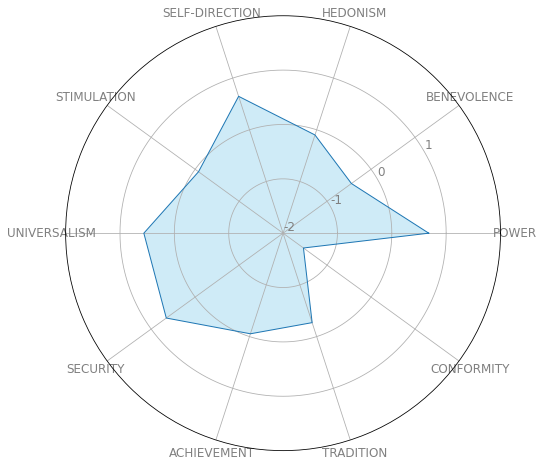

In [ ]:
batch_size=10
inference('not wanting people to use my property without permis')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


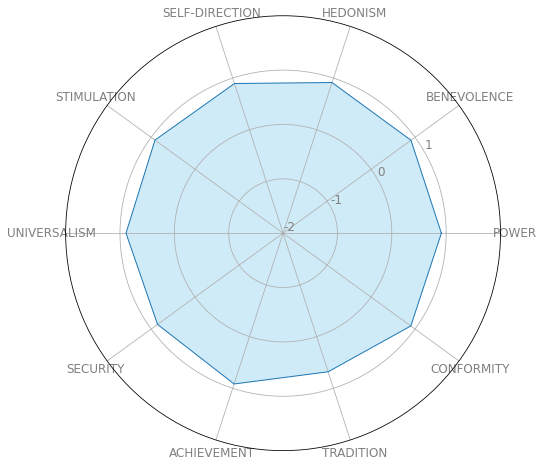

In [ ]:
inference('i love you ')